In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

import seaborn as sns
import pandas as pd

In [2]:
plt.style.use("seaborn-whitegrid")

In [11]:
Ls = [20, 50, 100, 200, 400, 800]

seeds = [24069, 99846, 24074, 57866, 72202, 9230, 24592, 97298, 49689, 85534, 83999, 58401, 93220, 40485, 6720, 67, 29256, 2640, 60498, 56406, 10326, 41049, 69216, 18535, 34408, 82026, 3691, 42091, 83573, 69242, 87163, 24701, 32897, 38018, 82561, 71302, 64647, 60553, 56971, 48270, 82575, 78992, 59537, 28306, 73362, 68241, 91288, 7323, 50333, 79517, 50847, 97439, 25762, 49314, 8357, 17068, 73909, 12992, 33990, 46279, 80072, 51915, 39121, 33493, 19161, 60121, 30939, 79071, 20192, 27372, 61166, 40690, 39673, 761, 40185, 47868, 78589, 68354, 67845, 3846, 73477, 53002, 86282, 35093, 81686, 80667, 30495, 65321, 36651, 61236, 69436, 19776, 49985, 63297, 86851, 69958, 84301, 23385, 86878, 37216]
p_c = .9 # probability of being assigned strategy C
for L in Ls:
    for idx, seed in enumerate(seeds):
        np.random.seed(seed)
        np.save("fields/field_{}_{}.npy".format(L, idx), np.random.choice((0, 1), (L, L), p=(1-p_c, p_c)))

In [13]:
config = {
        "GameType": "MeanGamePy",
        "parameters": [1.62179177],
        "steps":
        {
                "drop": 10000,
                "measure": 10
        },
        "results":
        {
                "dir": "./data",
                "name": "InPoiny"
        },
        "fields":
        {
                "size": 200,
                "dir": "./fields",
                "quantity": 100
        },
        "persistence":
        {
                "start": 10000,
                "end": 16000
        }
}


In [1]:
b = [1.51525424, 1.52146893, 1.52768362, 1.53389831, 1.540113  ,
       1.54632768, 1.55254237, 1.55875706, 1.56497175, 1.57118644,
       1.58983051, 1.60048426, 1.61113802, 1.62179177, 1.63244552,
       1.64309927, 1.65375303, 1.66440678]

In [14]:
import json

In [2]:
len(b)

18

In [16]:
for i, L in enumerate(Ls):
    config["fields"]["size"] = L
    config["results"]["name"] = f"InPoint{L}"
    with open(f"config{i+1}.json", "w") as f:
        json.dump(config, f)

In [17]:
i

5

## Transition values(local)

The game is defined by the payoff $b$ and different behaviour is expected at different $b$

To find the values of $b$ at which transition occurs we have to understand at which values the total outcome of agent may change.


<img src="./figures/neighbourhoods.png" alt="drawing" width="300"/>

By looking at picture above we can come up with this formuls for $b$
$$b=\frac{n_{c\;shared}+n_c+f_c}{n_{c\;shared}+n_d+f_c+1}$$
for left hand side configurations

$$b=\frac{n_{c\;shared}+n_c+f_c}{n_{c\;shared}+n_d+f_c}$$
for right hand side configurations

Where

$n_{c\;shared}$ - number of cooperators($\mathcal{C}$) from red region

$n_c$ - number of cooperators near cooperator(purple region)

$n_d$ - number of cooperators near defector(yellow region)

$f_c$ - density of cooperators

Both these formulas can be generalized as
$$b=\frac{m+f_c}{n+f_c}$$

In [3]:
def trans_val(f_c, m, n):
    return (m+f_c)/(n+f_c)

def trans_novak_may(m, n):
    return m/n

In [4]:
f_cs = np.linspace(0, 1, 20)

In [5]:
all_transitions = []
old_transitions = []

for m in range(0, 9):
    for n in range(0, 9):
        if n == 0:
            all_transitions.append(trans_val(np.linspace(0.00000001, 1, 20), m, n))
        else:
            all_transitions.append(trans_val(f_cs, m, n))
            old_transitions.append(m/n)

In [6]:
transitions = []
for i, tr in enumerate(all_transitions[:-1]):
    if not (np.square(np.array(all_transitions[i+1:]) - tr).sum(-1) < 0.0000001).any():
        transitions.append(tr)
transitions.append(all_transitions[-1])

transitions_old = []
for i, tr in enumerate(old_transitions[:-1]):
    if not (np.square(np.array(old_transitions[i+1:]) - tr) < 0.0000001).any():
        transitions_old.append(tr)
transitions_old.append(old_transitions[-1])

In [7]:
transitions_old = np.array(sorted(transitions_old))
transitions_old = transitions_old[(transitions_old >= 1) & (transitions_old <= 2)]

Values of transitions for the game with itself were taken from the article "The spatial dilemmas of evolution" by A. Novak and M. May, 1993

# N-M distribution

In [3]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'))

In [4]:
bs = [1.5       , 1.50689655, 1.5137931 , 1.52068966, 1.52758621,
      1.53448276, 1.54137931, 1.54827586, 1.55517241, 1.56206897,
      1.56896552, 1.57586207, 1.58275862, 1.58965517, 1.59655172,
      1.60344828, 1.61034483, 1.61724138, 1.62413793, 1.63103448,
      1.63793103, 1.64482759, 1.65172414, 1.65862069]
nm = np.load("data/200x200run/nmdistribution.npy").reshape((-1, 9, 9))
cluster_sizes = np.load("data/200x200run/clustersizedist.npy")
persistence = np.load("data/200x200run/persistence.npy")
density = np.load("data/200x200run/density.npy")

<IPython.core.display.Javascript object>


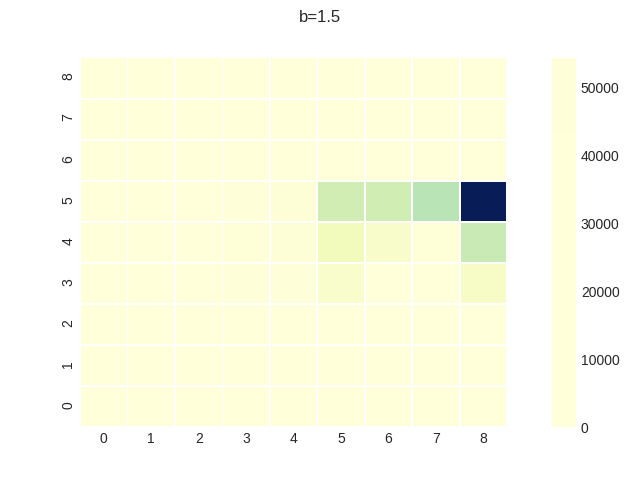

In [5]:
grid_kws = {"width_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws)

mx = nm.max()
sns.heatmap(nm[0][::-1], linewidth=0.5, yticklabels=range(8, -1, -1), cmap="YlGnBu",ax=ax,
                     cbar_ax=cbar_ax,
                     vmax=mx,
                     cbar_kws={"orientation": "vertical"})
def animate(i):
    plt.suptitle(f"b={bs[i]}")
    p = sns.heatmap(nm[i][::-1], linewidth=0.5, yticklabels=range(8, -1, -1), cmap="YlGnBu",ax=ax,
                     cbar_ax=cbar_ax,
                    vmax=mx,
                     cbar_kws={"orientation": "vertical"})
    
ani = animation.FuncAnimation(f, animate, frames=24, repeat=True)
ani.save("nmdistribution.mp4", writer=writer, dpi=300)

# Cluster sizes

In [27]:
i = 0
max_s = 250
clusts = {
    "class": ['D']*(max_s-2) + ['C']*(max_s-2),
    "size": list(range(2, max_s)) + list(range(2, max_s)),
    "value": cluster_sizes[0, i, 2:max_s].tolist() + cluster_sizes[1, i, 2:max_s].tolist()
}
data = pd.DataFrame(clusts, columns=["class", "value", "size"])

NameError: name 'cluster_sizes' is not defined

<IPython.core.display.Javascript object>


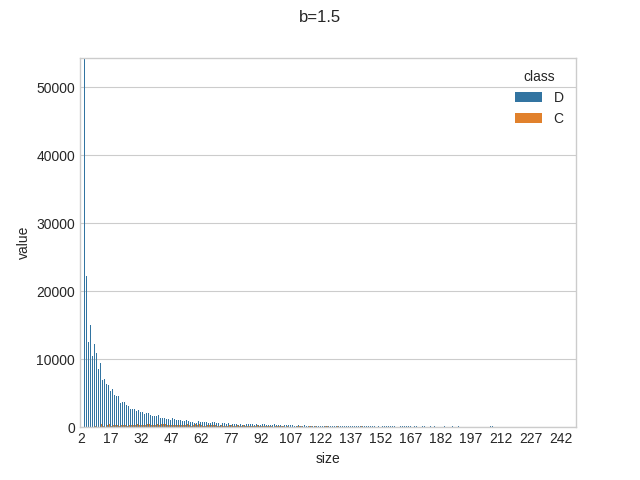

In [7]:
plt.ylim(0, cluster_sizes[1, :, 2:250].max())
grid_kws = {"width_ratios": (1,)}
f, ax = plt.subplots(1, 1, gridspec_kw=grid_kws)

mx = nm.max()
p = sns.barplot(x="size", y="value", hue="class", data=data,ax=ax)
for ind, label in enumerate(p.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)


def animate(i):
    clusts["value"] = cluster_sizes[0, i, 2:max_s].tolist() + cluster_sizes[1, i, 2:max_s].tolist()
    data = pd.DataFrame(clusts, columns=["class", "value", "size"])
    ax.clear()
    plt.ylim(0, cluster_sizes[1, :, 2:max_s].max())
    plt.suptitle(f"b={bs[i]}")
    p = sns.barplot(x="size", y="value", hue="class", data=data,ax=ax)
    for ind, label in enumerate(p.get_xticklabels()):
        if ind % 15 == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    
ani = animation.FuncAnimation(f, animate, frames=24, repeat=True)
ani.save("clus.mp4", writer=writer, dpi=300)

In [33]:
cluster_sizes.shape

(2, 3, 38934)

In [11]:
cluster_sizes = np.load("data/clusters/clustersizedist.npy")
cluster_sizes = cluster_sizes/(cluster_sizes.sum(axis=-1).reshape((2, -1, 1)))

i = 2
max_s = 30000
clusts = {
    "class": ['D']*(max_s-1) + ['C']*(max_s-1),
    "size": list(range(1, max_s)) + list(range(1, max_s)),
    "value": cluster_sizes[0, i, 1:max_s].tolist() + cluster_sizes[1, i, 1:max_s].tolist()
}
data = pd.DataFrame(clusts, columns=["class", "value", "size"])

In [12]:
len(clusts["class"]), len(clusts["size"]), len(clusts["value"])

(59998, 59998, 59998)

In [15]:
# b = [1.1, 1.59, 1.87]
for i in range(len(b)):
    clusts = {
        "class": ['D']*(cluster_sizes[0, i].shape[0]) + ['C']*(cluster_sizes[1, i].shape[0]),
        "size": list(range(0, cluster_sizes[0, i].shape[0])) + list(range(0, cluster_sizes[1, i].shape[0])),
        "value": cluster_sizes[0, i].tolist() + cluster_sizes[1, i].tolist()
    }
    data = pd.DataFrame(clusts, columns=["class", "value", "size"])
    data.to_csv(f"clusters_b={b[i]}.csv")

In [16]:
len(clusts["size"]), len(clusts["value"]), len(clusts["class"])

(67766, 67766, 67766)

In [17]:
cluster_sizes[0, i].shape

(33883,)

<IPython.core.display.Javascript object>


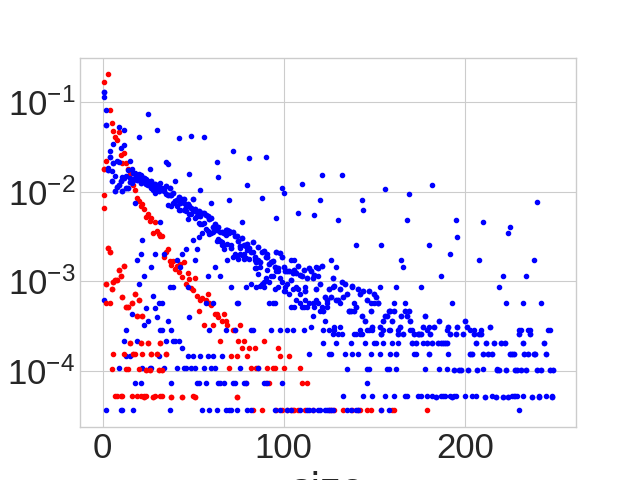

In [55]:
fig = plt.figure()
i = 1
total = np.array(cluster_sizes[0, i, 1:max_s].tolist() + cluster_sizes[1, i, 1:max_s].tolist()).sum()
deff = np.array(cluster_sizes[0, i, :max_s].tolist())/total
coop = np.array(cluster_sizes[1, i, :max_s].tolist())/total
plt.plot(range(deff.size), deff, ".r")
plt.plot(range(coop.size), coop, ".b")
plt.yscale("log")
# plt.xscale("log")

In [27]:
deff.shape

(33883,)

<IPython.core.display.Javascript object>


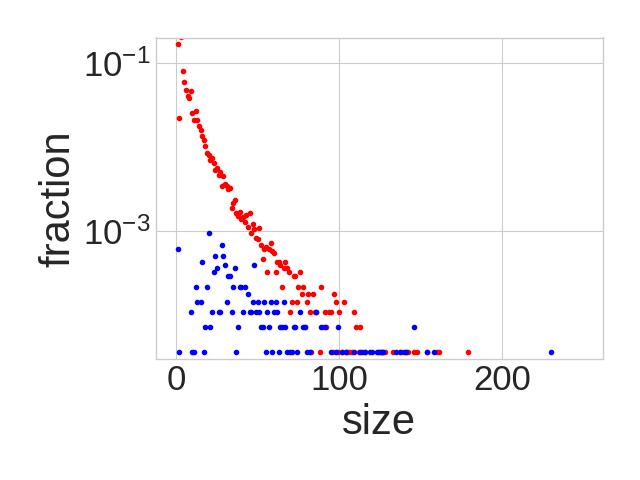

<IPython.core.display.Javascript object>


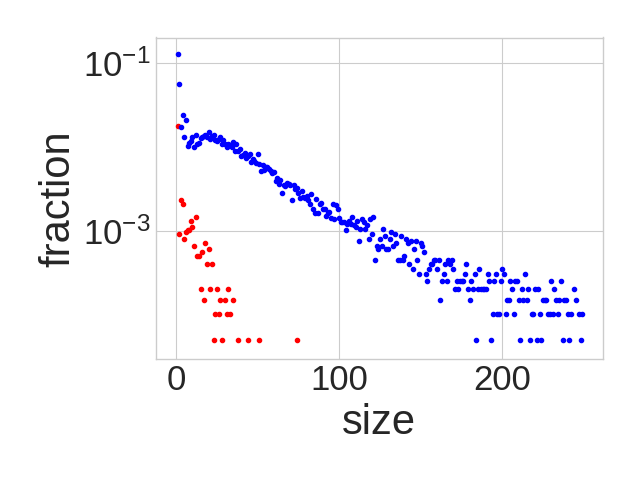

<IPython.core.display.Javascript object>


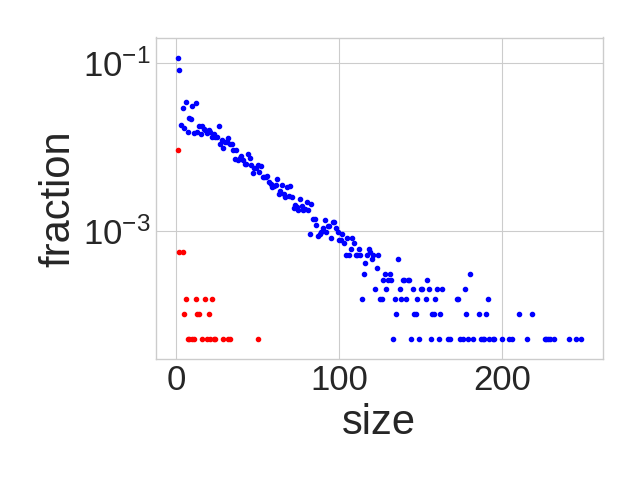

<IPython.core.display.Javascript object>


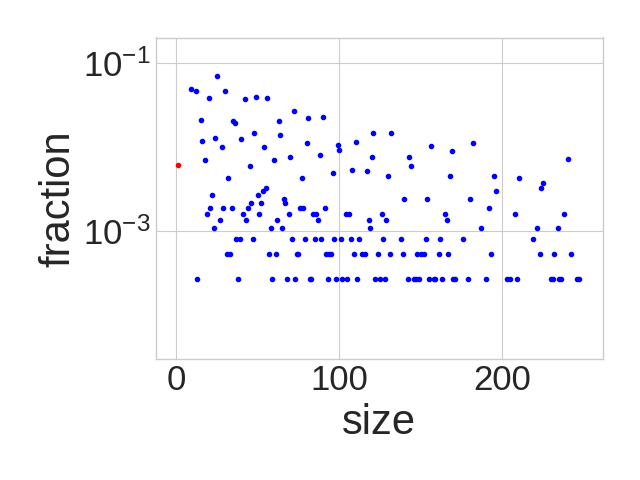

In [11]:
plt.rcParams.update({'font.size': 25})
cluster_sizes = np.load("data/clusters/clustersizedist.npy")/40
b = [1.2, 1.55, 1.59, 1.63]
max_s = 250
L = 200
for i in range(len(b)):
    total = np.array(cluster_sizes[0, i, :].tolist() + cluster_sizes[1, i, :].tolist()).sum()
    deff = np.array(cluster_sizes[0, i, :max_s].tolist())/total
    coop = np.array(cluster_sizes[1, i, :max_s].tolist())/total
    fig = plt.figure()
    plt.plot(range(deff.size), deff, ".r")
    plt.plot(range(coop.size), coop, ".b")
    plt.yscale("log")
#     p.set_xscale("log")
#     for ind, label in enumerate(p.get_xticklabels()):
#         if ind % 20 == 0:  # every 10th label is kept
#             label.set_visible(True)
#         else:
#             label.set_visible(False)
    
    plt.xlabel("size", fontsize=30)
    plt.ylabel("fraction", fontsize=30)
    plt.ylim((3e-5, .2))
    plt.tight_layout()
    plt.savefig(f"figures/clust_sizes_log_b={int(b[i]*100)}.png", dpi=100)

# Square Grid

In [7]:
bs = np.array([0.9      , 0.91864407, 0.93728814, 0.9559322 , 0.97457627,
     0.99322034, 1.01186441, 1.03050847, 1.04915254, 1.06779661,
     1.08644068, 1.10508475, 1.12372881, 1.14237288, 1.16101695,
     1.17966102, 1.19830508, 1.21694915, 1.23559322, 1.25423729,
     1.27288136, 1.29152542, 1.31016949, 1.32881356, 1.34745763,
     1.36610169, 1.38474576, 1.40338983, 1.4220339 , 1.44067797,
     1.45932203, 1.4779661 , 1.49661017, 1.51525424, 1.526     ,
     1.53389831, 1.55254237, 1.57118644, 1.58983051, 1.60847458,
     1.618     , 1.62711864, 1.64576271, 1.66440678, 1.68305085,
     1.70169492, 1.72033898, 1.73898305, 1.75762712, 1.77627119,
     1.79491525, 1.81355932, 1.83220339, 1.85084746, 1.86949153,
     1.88813559, 1.90677966, 1.92542373, 1.9440678 , 1.96271186,
     1.98135593, 2.0])

persistence_m = np.load("data/200MeanGame/persistence.npy")
density_m = np.load("data/200MeanGame/density.npy")

persistence_n = np.load("data/200NovakMayGame/persistence.npy")
density_n = np.load("data/200NovakMayGame/density.npy")

pers016 = np.load("data/pers016000.npy")

bs_extended = [1.51525424, 1.52146893, 1.52768362, 1.53389831, 1.540113  ,
       1.54632768, 1.55254237, 1.55875706, 1.56497175, 1.57118644,
       1.58983051, 1.60048426, 1.61113802, 1.62179177, 1.63244552,
       1.64309927, 1.65375303, 1.66440678]
persistence_me = np.load("data/Hyperbolas/persistence.npy")
density_me = np.load("data/Hyperbolas/density.npy")
st, en = np.arange(len(bs))[(bs == bs_extended[0]) | (bs == bs_extended[-1])]

In [16]:
persistence[1]

array([0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.8051  , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.8363  ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.818775, 0.      , 0.      , 0.      ,
       0.      , 0.83965 , 0.      , 0.      ])

In [12]:
bsn = [1.61113802, 1.62179177, 1.63244552]
density = np.load("data/MoreData/density.npy")
persistence = np.load("data/MoreData/persistence.npy")

In [13]:
plt.rcParams.update({'font.size': 18})

<IPython.core.display.Javascript object>


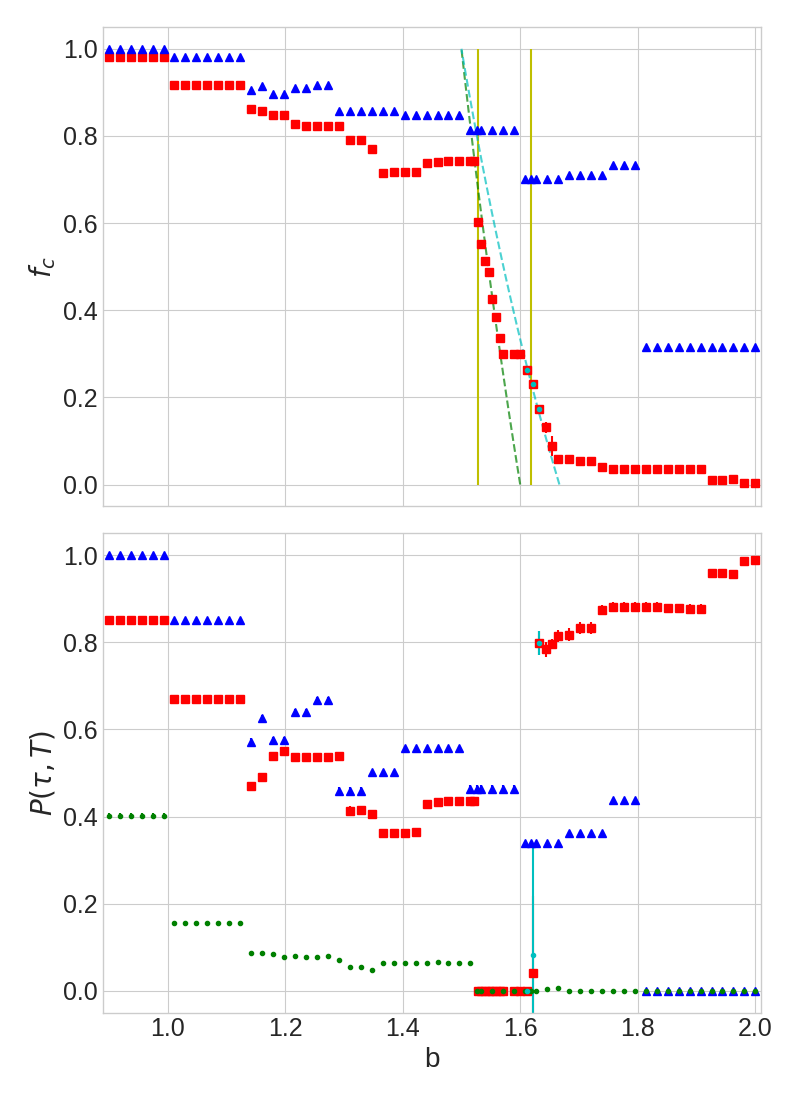

In [15]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,11))
# sns.set()
fig.subplots_adjust(hspace=.05)
plt.grid(True)
plt.setp(axs, xlim=(.89, 2.01), ylim=(-.05, 1.05))
# plt.xlim(.89, 2.01)
axs[0].errorbar(bs[:st], density_m[:st, :, 10000:].mean(axis=-1).mean(axis=-1), yerr=density_m[:st, :, 10000:].mean(axis=-1).std(axis=-1), fmt="sr", label="Mean-field game")
axs[0].errorbar(bs[en+1:], density_m[en+1:, :, 10000:].mean(axis=-1).mean(axis=-1), yerr=density_m[en+1:, :, 10000:].mean(axis=-1).std(axis=-1), fmt="sr")
axs[0].errorbar(bs_extended, density_me[:, :, 10000:].mean(axis=-1).mean(axis=-1), yerr=density_me[:, :, 10000:].mean(axis=-1).std(axis=-1), fmt="sr")

axs[0].errorbar(bs, density_n[:, :, 10000:].mean(axis=-1).mean(axis=-1), yerr=density_n[:, :, 10000:].mean(axis=-1).std(axis=-1), fmt="^b", label="Nowak-May game")

axs[0].plot(trans_val(f_cs, 8, 5), f_cs, "g--", alpha=.7)
axs[0].plot(trans_val(f_cs, 5, 3), f_cs, "c--", alpha=.7)

bs_extended = np.array(bs_extended)
mn, mx = bs_extended[persistence_me.mean(axis=-1) < 2/40000].min(), bs[persistence_m.mean(axis=-1) < 2/40000].max()
axs[0].vlines(mn, 0, 1, "y")
axs[0].vlines(mx, 0, 1, "y")
# plt.vlines()
axs[0].set_ylabel("$f_c$", fontsize=20)

axs[0].errorbar(bsn, density[:, :, 10000:].mean(axis=-1).mean(axis=-1), yerr=density[:, :, 10000:].mean(axis=-1).std(axis=-1), fmt=".c")

# axs[0].plot(bs[:st], persistence_m[:st].mean(axis=-1), "r", label="Mean-field game")
# axs[0].plot(bs[en+1:], persistence_m[en+1:].mean(axis=-1), "r")
# axs[0].plot(bs_extended, persistence_me.mean(axis=-1), "r")


axs[1].errorbar(bs[:st], persistence_m[:st].mean(axis=-1), yerr=persistence_m[:st].std(axis=-1), fmt="sr", label="Mean-field game")
axs[1].errorbar(bs[en+1:], persistence_m[en+1:].mean(axis=-1), yerr=persistence_m[en+1:].std(axis=-1), fmt="sr")
axs[1].errorbar(bs_extended, persistence_me.mean(axis=-1), yerr=persistence_me.std(axis=-1), fmt="sr")
# axs[1].errorbar(bs, persistence_m.mean(axis=-1), yerr=persistence_m.std(axis=-1), fmt="sr", label="Mean-field game")
# plt.plot(bs, persistence_m.mean(axis=-1), "-r", alpha=.4)
axs[1].errorbar(bs, persistence_n.mean(axis=-1), yerr=persistence_n.std(axis=-1), fmt="^b", label="Nowak-May game")
# plt.plot(bs, persistence_n.mean(axis=-1), "-b", alpha=.4)

axs[1].errorbar(bs, pers016.mean(axis=-1), yerr=pers016.std(axis=-1), fmt=".g", label="0-16000")
# plt.plot(bs, pers016.mean(axis=-1), "-g", alpha=.4)
axs[1].errorbar(bsn, persistence.mean(axis=-1), yerr=persistence.std(axis=-1), fmt=".c")
axs[1].set_xlabel("b", fontsize=20)
axs[1].set_ylabel(r"$P(\tau, T)$", fontsize=20)
plt.tight_layout()



# plt.legend(loc="lower left")
plt.savefig("figures/density_persistence_NMMF.png", dpi=150)

In [11]:
persistence.shape

(3, 40, 30001)

In [26]:
bs_extended[12:15]

array([1.61113802, 1.62179177, 1.63244552])

In [41]:
axs

array([[<AxesSubplot:>],
       [<AxesSubplot:>]], dtype=object)

In [76]:
dens = density_m[:, :, 10000:].mean(axis=-1).mean(axis=-1)
bs = np.array(bs)
custd = (5 - bs*3)/(bs - 1)

In [79]:
bs[w]

array([1.58983051, 1.60847458, 1.618     , 1.62711864, 1.64576271,
       1.66440678])

<IPython.core.display.Javascript object>


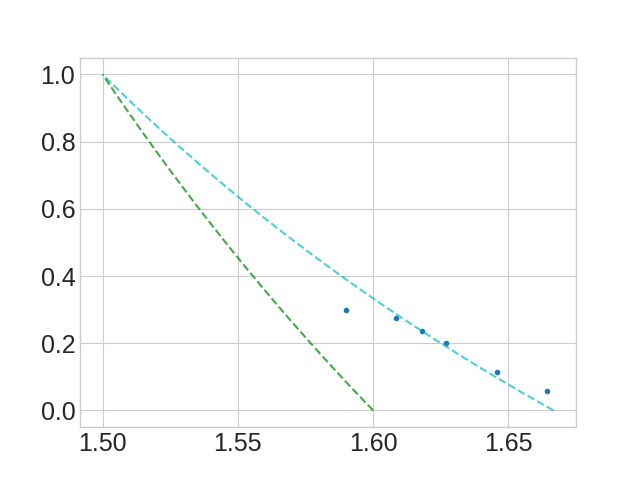

In [78]:
fig = plt.figure()
w = (np.abs(dens - custd) < .1)
plt.plot(bs[w], dens[w], ".")
plt.plot(trans_val(f_cs, 8, 5), f_cs, "g--", alpha=.7)
plt.plot(trans_val(f_cs, 5, 3), f_cs, "c--", alpha=.7)

In [58]:
np.array(bs)[persistence_m.mean(axis=-1), yerr=persistence_m.std(axis=-1) == 0]

array([1.526     , 1.53389831, 1.55254237, 1.57118644, 1.58983051,
       1.60847458, 1.618     ])

<IPython.core.display.Javascript object>


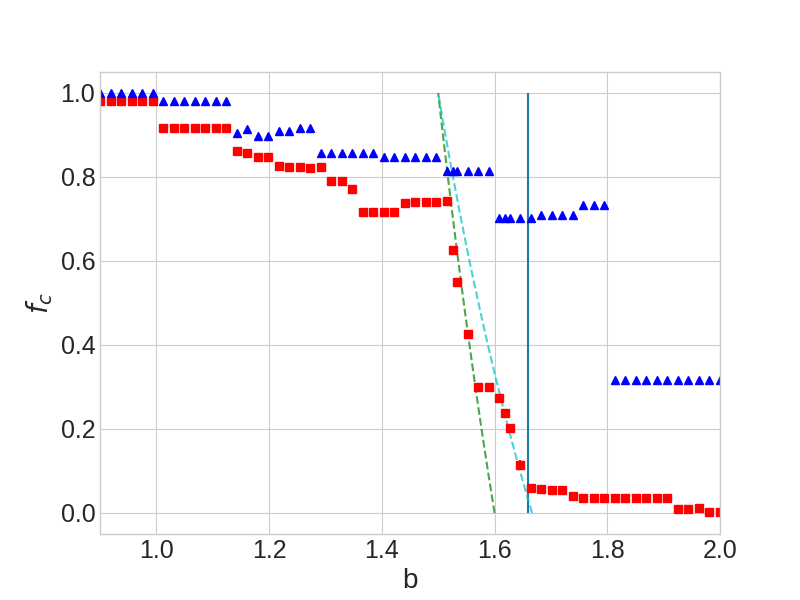

Text(0, 0.5, '$f_c$')

In [11]:
# sns.set()
plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.grid(True)
plt.xlim(.9, 2)
plt.errorbar(bs, density_m[:, :, 10000:].mean(axis=-1).mean(axis=-1), yerr=density_m[:, :, 10000:].mean(axis=-1).std(axis=-1), fmt="sr", label="Mean-field game")
plt.errorbar(bs, density_n[:, :, 10000:].mean(axis=-1).mean(axis=-1), yerr=density_n[:, :, 10000:].mean(axis=-1).std(axis=-1), fmt="^b", label="Nowak-May game")

plt.plot(trans_val(f_cs, 8, 5), f_cs, "g--", alpha=.7)
plt.plot(trans_val(f_cs, 5, 3), f_cs, "c--", alpha=.7)

# plt.hlines(12*np.log(2) - 8, 1.53, 1.63, 'c', 'dashed')
# plt.hlines(0.293, 1.53, 1.63, 'g', 'dashed')
# plt.plot(bs, persistence_m.mean(axis=-1), "b-", alpha=.5)
# plt.plot(bs, persistence_n.mean(axis=-1), "y-", alpha=.5)

plt.vlines(1.66, 0, 1)
# plt.hlines(0.5, 1, 2)

plt.xlabel("b", fontsize=20)
plt.ylabel("$f_c$", fontsize=20)

# plt.legend(loc="lower left")
# plt.savefig("figures/density_NovakMay_Mean_game.png", dpi=150)

In [13]:
bs[np.argmin(np.abs(np.array(bs) - 1.52))], bs[np.argmin(np.abs(np.array(bs) - 1.66))]

(1.51525424, 1.66440678)

In [15]:
bs[np.argmin(np.abs(np.array(bs) - 1.52)):np.argmin(np.abs(np.array(bs) - 1.66))+1]

[1.51525424,
 1.526,
 1.53389831,
 1.55254237,
 1.57118644,
 1.58983051,
 1.60847458,
 1.618,
 1.62711864,
 1.64576271,
 1.66440678]

In [18]:
np.concatenate((np.linspace(1.51525424, 1.57118644, 10), np.linspace(1.58983051, 1.66440678, 8)))

array([1.51525424, 1.52146893, 1.52768362, 1.53389831, 1.540113  ,
       1.54632768, 1.55254237, 1.55875706, 1.56497175, 1.57118644,
       1.58983051, 1.60048426, 1.61113802, 1.62179177, 1.63244552,
       1.64309927, 1.65375303, 1.66440678])

In [34]:
# b2 = [0.9, 0.99322034, 1.01186441, 1.10508475, 1.21694915,
#      1.31016949, 1.4220339 , 1.49661017, 1.51525424, 1.526     ,
#      1.53389831, 1.55254237, 1.57118644, 1.58983051, 1.60847458,
#      1.618     , 1.62711864, 1.64576271, 1.66440678, 1.68305085,
#      1.70169492, 1.72033898, 1.73898305, 1.81355932, 1.90677966, 1.96271186, 2.0]

pers016 = np.load("data/pers016000.npy")
# pers016100 = np.load("data/pers016000-100.npy")

<IPython.core.display.Javascript object>


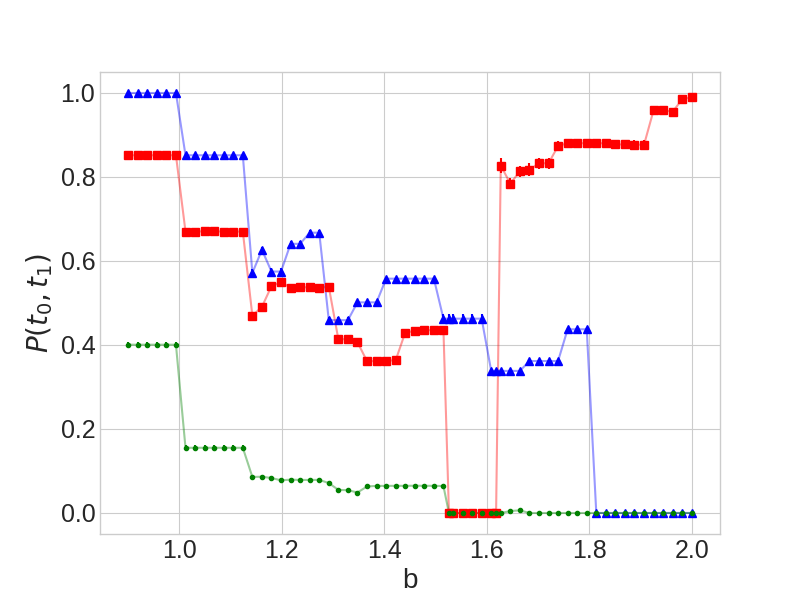

In [15]:
# 
# sns.set_palette("Pastel2_r")
# sns.set()# sns.set()
plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.grid(True)
plt.errorbar(bs, persistence_m.mean(axis=-1), yerr=persistence_m.std(axis=-1), fmt="sr", label="Mean-field game")
plt.plot(bs, persistence_m.mean(axis=-1), "-r", alpha=.4)
plt.errorbar(bs, persistence_n.mean(axis=-1), yerr=persistence_n.std(axis=-1), fmt="^b", label="Nowak-May game")
plt.plot(bs, persistence_n.mean(axis=-1), "-b", alpha=.4)

plt.errorbar(bs, pers016.mean(axis=-1), yerr=pers016.std(axis=-1), fmt=".g", label="0-16000")
plt.plot(bs, pers016.mean(axis=-1), "-g", alpha=.4)

plt.xlabel("b", fontsize=20)
plt.ylabel("$P(t_0, t_1)$", fontsize=20)
# plt.legend(loc='lower left')
plt.savefig("figures/persistence_square.png", dpi=150)

In [16]:
pers016.mean(axis=-1)*40000

array([1.6029600e+04, 1.6029475e+04, 1.6029475e+04, 1.6029475e+04,
       1.6029475e+04, 1.6029475e+04, 6.2083000e+03, 6.2118250e+03,
       6.2113500e+03, 6.2114500e+03, 6.2097500e+03, 6.2073750e+03,
       6.2106750e+03, 3.4305250e+03, 3.4547750e+03, 3.3324000e+03,
       3.1128500e+03, 3.1753750e+03, 3.1470000e+03, 3.1469500e+03,
       3.1510750e+03, 2.8534500e+03, 2.1958500e+03, 2.1734000e+03,
       1.9494000e+03, 2.5251500e+03, 2.5806250e+03, 2.5831000e+03,
       2.5899000e+03, 2.5861250e+03, 2.6003500e+03, 2.5886500e+03,
       2.5886500e+03, 2.5666000e+03, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0500000e+00, 1.8525000e+02, 2.5342500e+02,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [5]:
b2 = [0.9, 0.99322034, 1.01186441, 1.10508475, 1.21694915,
     1.31016949, 1.4220339 , 1.49661017, 1.51525424, 1.526     ,
     1.53389831, 1.55254237, 1.57118644, 1.58983051, 1.60847458,
     1.618     , 1.62711864, 1.64576271, 1.66440678, 1.68305085,
     1.70169492, 1.72033898, 1.73898305, 1.81355932, 1.90677966, 1.96271186, 2.0]

pers016 = np.load("data/pers016000.npy")
pers016100 = np.load("data/pers016000-100.npy")

<IPython.core.display.Javascript object>


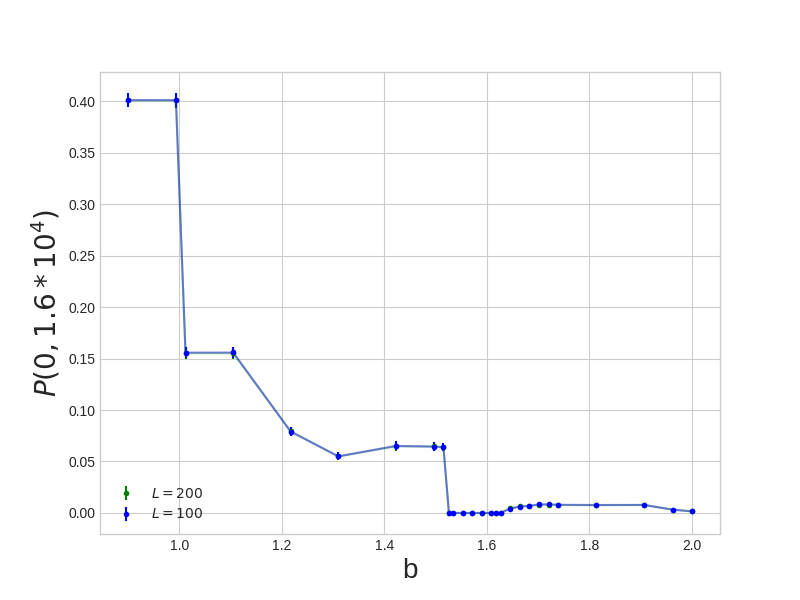

In [6]:
# 
# sns.set_palette("Pastel2_r")
# sns.set()# sns.set()
plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.grid(True)
plt.errorbar(b2, pers016.mean(axis=-1), yerr=pers016.std(axis=-1), fmt=".g", label="$L=200$")
plt.plot(b2, pers016.mean(axis=-1), "-g", alpha=.4)
plt.errorbar(b2, pers016100.mean(axis=-1), yerr=pers016.std(axis=-1), fmt=".b", label="$L=100$")
plt.plot(b2, pers016100.mean(axis=-1), "-b", alpha=.4)

plt.xlabel("b", fontsize=20)
plt.ylabel("$P(0, 1.6*10^4)$", fontsize=20)
plt.legend(loc='lower left')
# plt.savefig("figures/persistence_square.png", dpi=150)

# Triangular game

In [9]:
persistence_m = np.load("data/MeanTriangle/persistence.npy")
density_m = np.load("data/MeanTriangle/density.npy")

persistence_n = np.load("data/NovakMayTriangle/persistence.npy")
density_n = np.load("data/NovakMayTriangle/density.npy")
bs = [0.9       , 0.91864407, 0.93728814, 0.9559322 , 0.97457627,
     0.99322034, 1.01186441, 1.03050847, 1.04915254, 1.06779661,
     1.08644068, 1.10508475, 1.12372881, 1.14237288, 1.16101695,
     1.17966102, 1.19830508, 1.21694915, 1.23559322, 1.25423729,
     1.27288136, 1.29152542, 1.31016949, 1.32881356, 1.34745763,
     1.36610169, 1.38474576, 1.40338983, 1.4220339 , 1.44067797,
     1.45932203, 1.4779661 , 1.49661017, 1.51525424, 1.53389831,
     1.55254237, 1.57118644, 1.58983051, 1.60847458, 1.62711864,
     1.64576271, 1.66440678, 1.68305085, 1.70169492, 1.72033898,
     1.73898305, 1.75762712, 1.77627119, 1.79491525, 1.81355932,
     1.83220339, 1.85084746, 1.86949153, 1.88813559, 1.90677966,
     1.92542373, 1.9440678 , 1.96271186, 1.98135593, 2.0]

<IPython.core.display.Javascript object>


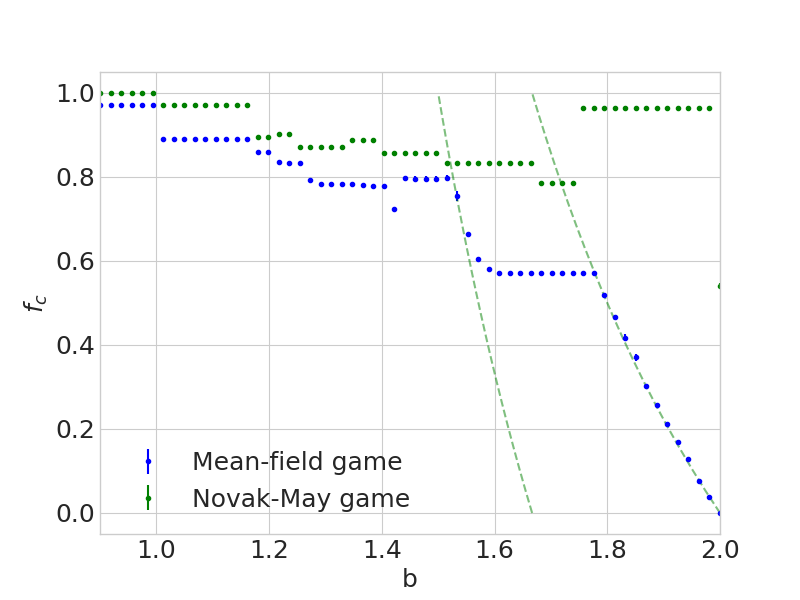

In [12]:
# sns.set()
plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.grid(True)
plt.xlim(.9, 2)
plt.errorbar(bs, density_m[:, :, 10000:].mean(axis=-1).mean(axis=-1), yerr=density_m[:, :, 10000:].mean(axis=-1).std(axis=-1), fmt=".b", label="Mean-field game")
plt.errorbar(bs, density_n[:, :, 10000:].mean(axis=-1).mean(axis=-1), yerr=density_n[:, :, 10000:].mean(axis=-1).std(axis=-1), fmt=".g", label="Novak-May game")
plt.plot(trans_val(f_cs, 5, 3), f_cs, "g--", alpha=.5)
plt.plot(trans_val(f_cs, 4, 2), f_cs, "g--", alpha=.5)

# plt.plot(bs, persistence_m.mean(axis=-1), "b-", alpha=.5)
# plt.plot(bs, persistence_n.mean(axis=-1), "y-", alpha=.5)
# plt.plot(bs, persistence_tr.mean(axis=-1), "-", color='orange', alpha=.4)
plt.xlabel("b")
plt.ylabel("$f_c$")
plt.legend(loc="lower left")
plt.savefig("figures/density_triangular.png", dpi=500, quality=95)

<IPython.core.display.Javascript object>


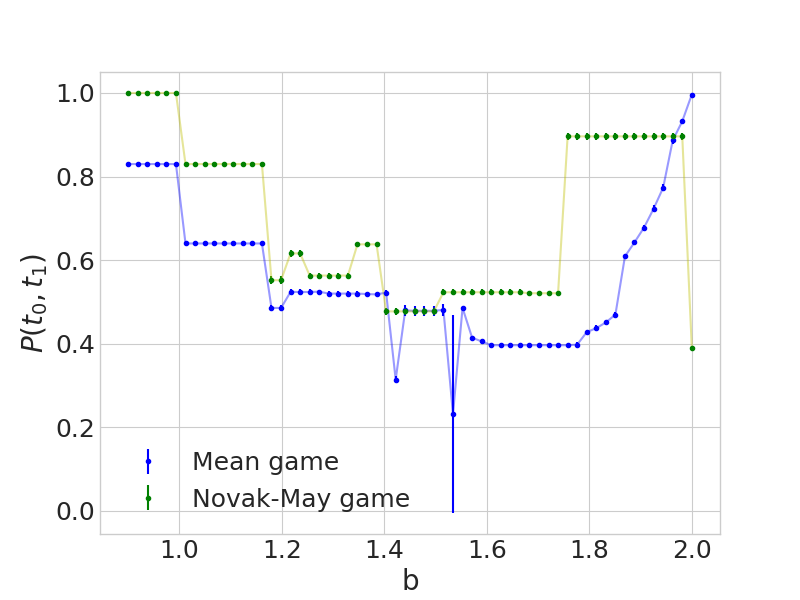

In [13]:
plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.grid(True)
plt.errorbar(bs, persistence_m.mean(axis=-1), yerr=persistence_m.std(axis=-1), fmt=".b", label="Mean-field game")
plt.plot(bs, persistence_m.mean(axis=-1), "-b", alpha=.4)
plt.errorbar(bs, persistence_n.mean(axis=-1), yerr=persistence_n.std(axis=-1), fmt=".g", label="Novak-May game")
plt.plot(bs, persistence_n.mean(axis=-1), "-y", alpha=.4)

plt.xlabel("b", fontsize=20)
plt.ylabel("$P(t_0, t_1)$", fontsize=20)
plt.legend(loc='lower left')
plt.savefig("figures/persistence_triangle.png", dpi=500, quality=95)

# CDCDCDC... type of agents

In [8]:
from spatgames import MeanGamePy, NovakMayGamePy
from tqdm.notebook import tqdm

In [9]:
L = 100
p_c = 0.9
burn = 5000
calc = 1000
N = 10
init_field = np.random.choice([0, 1], [N, L, L], p=(1 - p_c, p_c))
gameMF = MeanGamePy(L, 1.3)
gameNM = NovakMayGamePy(L, 1.3)
bs = [0.9, 0.91864407, 0.93728814, 0.9559322 , 0.97457627,
     0.99322034, 1.01186441, 1.03050847, 1.04915254, 1.06779661,
     1.08644068, 1.10508475, 1.12372881, 1.14237288, 1.16101695,
     1.17966102, 1.19830508, 1.21694915, 1.23559322, 1.25423729,
     1.27288136, 1.29152542, 1.31016949, 1.32881356, 1.34745763,
     1.36610169, 1.38474576, 1.40338983, 1.4220339 , 1.44067797,
     1.45932203, 1.4779661 , 1.49661017, 1.51525424, 1.526     ,
     1.53389831, 1.55254237, 1.57118644, 1.58983051, 1.60847458,
     1.618     , 1.62711864, 1.64576271, 1.66440678, 1.68305085,
     1.70169492, 1.72033898, 1.73898305, 1.75762712, 1.77627119,
     1.79491525, 1.81355932, 1.83220339, 1.85084746, 1.86949153,
     1.88813559, 1.90677966, 1.92542373, 1.9440678 , 1.96271186,
     1.98135593, 2.0]

In [10]:
densMF = []
densNM = []
for b in tqdm(bs):
    dMF = []
    dNM = []
    for f in range(N):
        countNM = np.zeros_like(init_field[f], dtype="int16")
        gameNM.field = init_field[f].copy()
        gameNM.b = b
        gameNM.evolve(burn)
        
        countMF = np.zeros_like(init_field[f], dtype="int16")
        gameMF.field = init_field[f].copy()
        gameMF.b = b
        gameMF.evolve(burn)
        for _ in range(calc):
            old_f_NM = gameNM.field.astype("int16")
            gameNM.evolve()
            new_f_NM = gameNM.field.astype("int16")
            countNM[new_f_NM != old_f_NM] += 1
            
            old_f = gameMF.field.astype("int16")
            gameMF.evolve()
            new_f = gameMF.field.astype("int16")
            countMF[new_f != old_f] += 1
            
        dNM.append((countNM == calc).sum()/L**2)
        dMF.append((countMF == calc).sum()/L**2)
    densNM.append(dNM)
    densMF.append(dMF)

In [11]:
np.save("data/DCDCDC_NM.npy", densNM)
np.save("data/DCDCDC_MF.npy", densMF)

In [28]:
burn = 5000
calc = 1000
N = 10
p_c = 0.9
density = []
for L in tqdm([10, 30, 50, 100]):
    init_field = np.random.choice([0, 1], [N, L, L], p=(1 - p_c, p_c))
    game = MeanGamePy(L, 1.3)
    dens = []
    for b in bs:
        d = []
        for f in range(N):
            count = np.zeros_like(init_field[f], dtype="int16")
            game.field = init_field[f].copy()
            game.b = b
            game.evolve(burn)
            for _ in range(calc):
                old_f = game.field.astype("int16")
                game.evolve()
                new_f = game.field.astype("int16")
                count[new_f != old_f] += 1
            d.append((count == calc).sum()/L**2)
        dens.append(np.mean(d))
    density.append(dens)

In [29]:
density = np.array(density)

In [28]:
# np.save("DCDCDC.npy", dens)
dens = np.load("DCDCDC.npy")

In [13]:
densMF = np.array(densMF)
densNM = np.array(densNM)

<IPython.core.display.Javascript object>


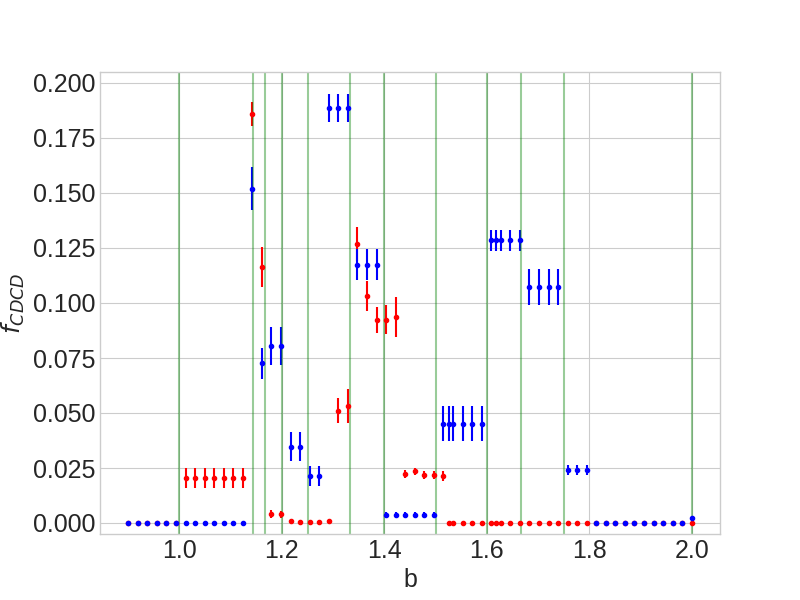

In [36]:
plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.grid(True)
plt.errorbar(bs, densMF.mean(axis=-1), yerr=densMF.std(axis=-1), fmt=".r", label="Novak-May game")
plt.errorbar(bs, densNM.mean(axis=-1), yerr=densNM.std(axis=-1), fmt=".b", label="Novak-May game")
# plt.plot(bs, dens.mean(axis=-1), "-b", alpha=.4)
# for b in transitions_old:
plt.vlines(transitions_old, -0.1, 0.25, colors="g", alpha=.4)
plt.ylim(-.005, 0.205)
plt.xlabel("b")
plt.ylabel("$f_{CDCD}$")
# plt.legend(facecolor='white', frameon = True, framealpha=1)

plt.savefig("figures/CDCDCD.png", dpi=100)
#     plt.plot(bs, dens[:, 1])

<IPython.core.display.Javascript object>


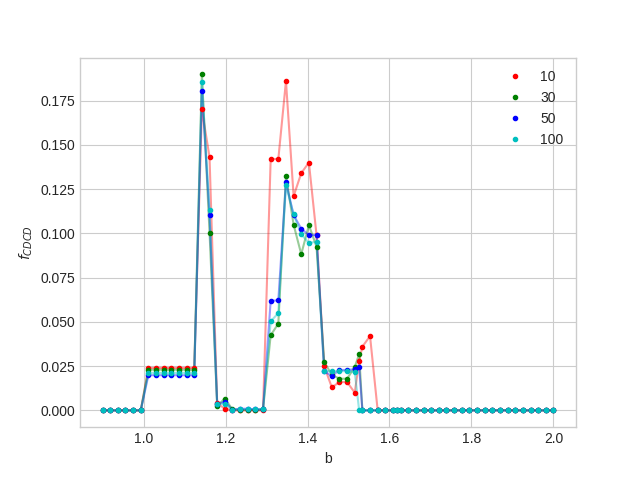

Text(0, 0.5, '$f_{CDCD}$')

In [38]:
fig = plt.figure()
for i, (L, c) in enumerate(zip([10, 30, 50, 100], ['r', 'g', 'b', 'c'])):
    plt.errorbar(bs, density[i], fmt="." + c, label=L)
    plt.plot(bs, density[i], "-" + c, alpha=.4)
plt.legend()
plt.xlabel("b")
plt.ylabel("$f_{CDCD}$")
#     plt.plot(bs, dens[:, 1])

In [15]:
count.max()

226

In [11]:
b = [1.2, 1.55, 1.59, 1.63]
cluster_sizes = np.load("data/clusters/clustersizedist.npy")

In [10]:
cluster_sizes.shape

(2, 4, 33883)

<IPython.core.display.Javascript object>


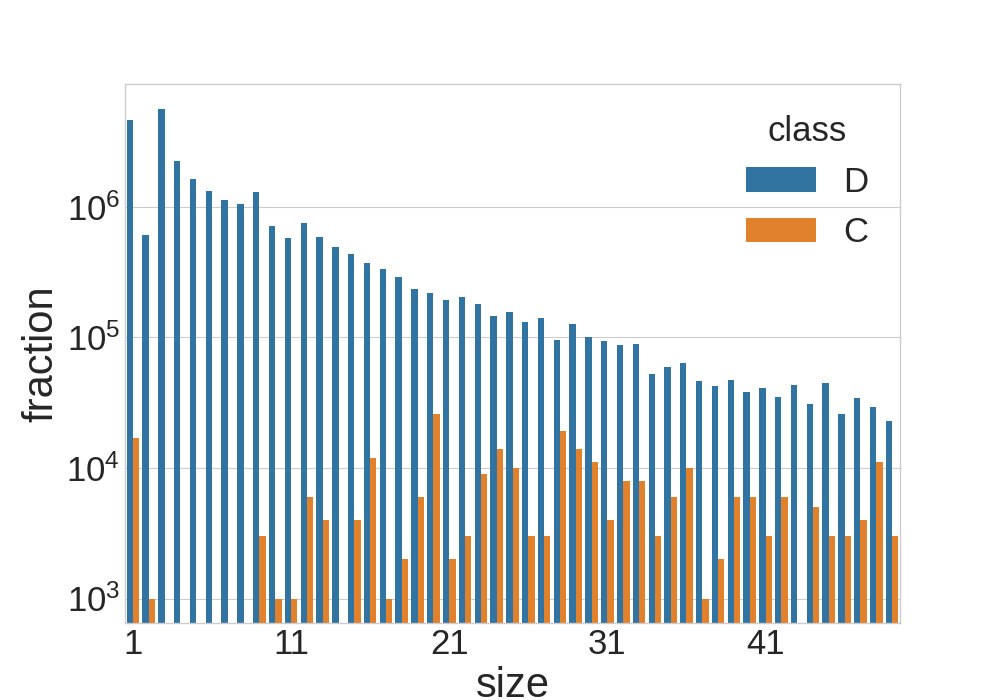

<IPython.core.display.Javascript object>


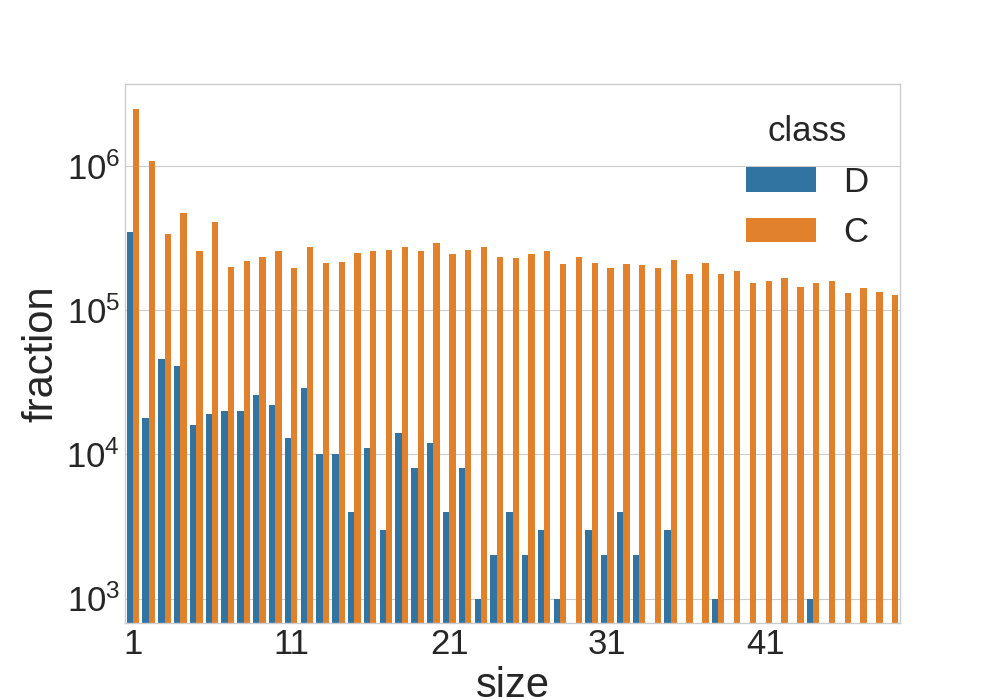

<IPython.core.display.Javascript object>


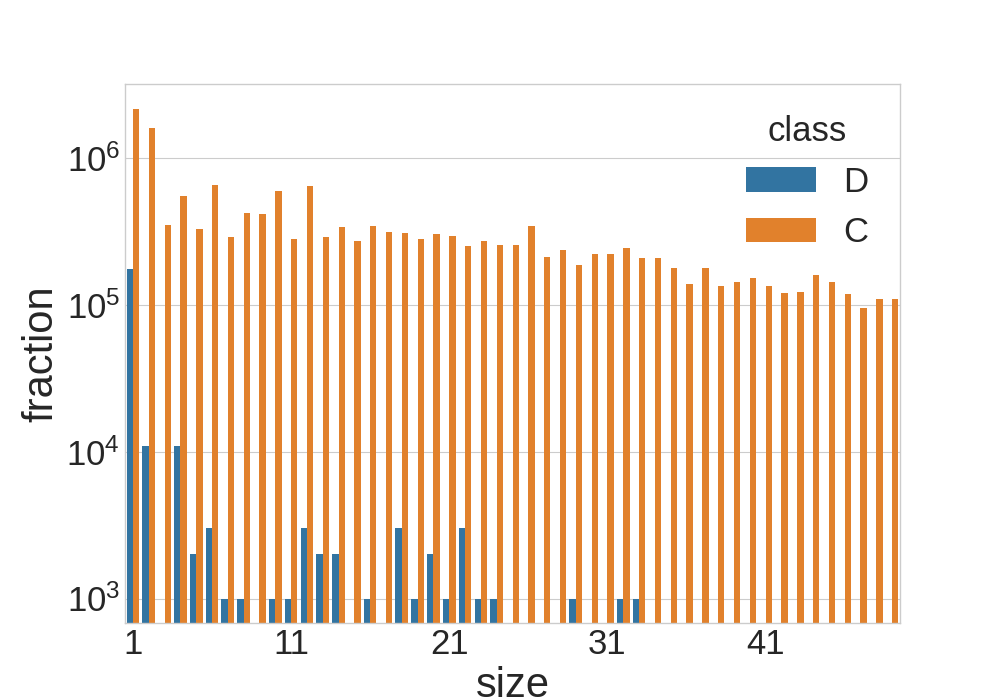

<IPython.core.display.Javascript object>


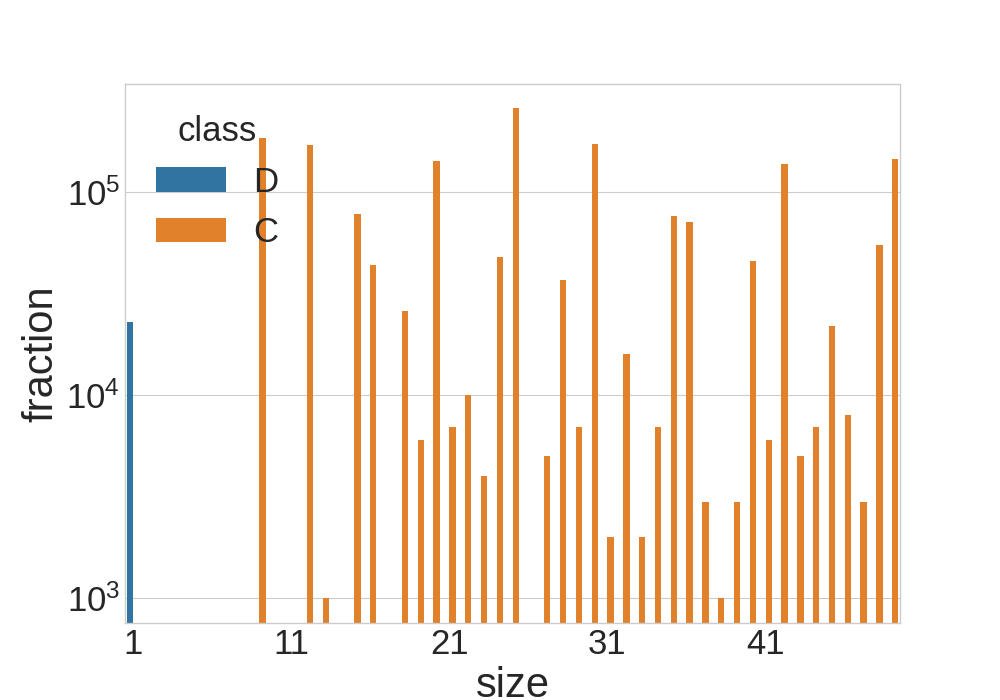

In [14]:
plt.rcParams.update({'font.size': 25})
max_s = 50
for i in range(len(b)):
    clusts = {
        "class": ['D']*(max_s-1) + ['C']*(max_s-1),
        "size": list(range(1, max_s)) + list(range(1, max_s)),
        "value": cluster_sizes[0, i, 1:max_s].tolist() + cluster_sizes[1, i, 1:max_s].tolist()
    }
    data = pd.DataFrame(clusts, columns=["class", "value", "size"])

    fig = plt.figure(figsize=(10, 7))
    plt.tight_layout()
    p = sns.barplot(x="size", y="value", hue="class", data=data)
    p.set_yscale("log")
#     p.set_xscale("log")
    for ind, label in enumerate(p.get_xticklabels()):
        if ind % 10 == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    plt.xlabel("size", fontsize=30)
    plt.ylabel("fraction", fontsize=30)
    plt.savefig(f"figures/clust_sizes_log_b={b[i]}.png", dpi=100)

# Long game

In [10]:
from spatgames import MeanGamePy
from tqdm.notebook import tqdm

In [35]:
bs = [1.62711864, 1.64576271]
L = 200
p_c_ = .9
b = 1.62711864
game = MeanGamePy(L, b, 15000, 100000)
np.random.seed(100)
field = np.random.choice((0, 1), (L, L), p=(1-p_c_, p_c_))
game.field = field

In [56]:
persistence_m.mean(axis=-1)[np.array(bs) == b]

array([0.8273375])

In [36]:
game.evolve(15000)

In [37]:
pers = []
changed = np.zeros_like(field)
for _ in tqdm(range(50000)):
    field_ = game.field.astype(int)
    game.evolve()
    pers.append(game.persistence)
    changed += field_ != game.field.astype(int)

<IPython.core.display.Javascript object>


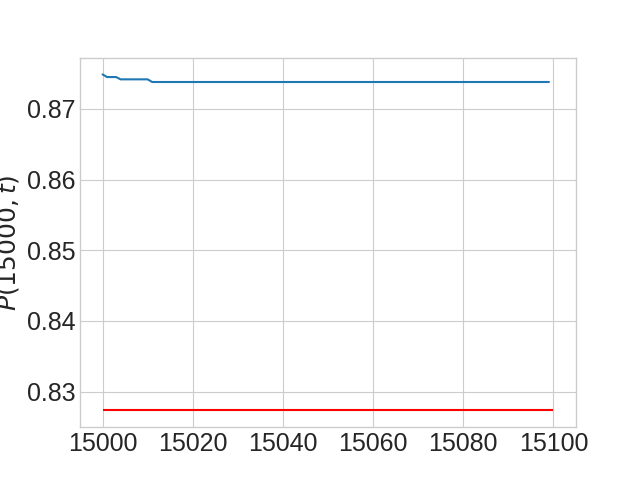

In [58]:
fig = plt.figure()
plt.plot(range(15000, 15100), pers[:100])
plt.ylabel("$P(15000, t)$")
plt.hlines(0.8273375, 15000, 15100, "r")
# plt.plot(game.densities[40000:41000])

In [47]:
time = 50000/changed

<ipython-input-47-e9b3eace1d19>:1: RuntimeWarning: divide by zero encountered in true_divide
  time = 50000/changed


In [53]:
time[np.isinf(time) == False].mean(), time[np.isinf(time) == False].std()

(1.6379418966603458, 0.22346711290491955)

In [52]:
changed.max()

33333

In [6]:
persistence

array([[[0.901875, 0.391975, 0.1827  , ..., 0.25495 , 0.30345 ,
         0.2541  ],
        [0.900925, 0.3918  , 0.175075, ..., 0.286975, 0.238375,
         0.279925],
        [0.9003  , 0.383775, 0.174925, ..., 0.2847  , 0.231025,
         0.27965 ],
        ...,
        [0.900125, 0.388575, 0.181425, ..., 0.23805 , 0.28605 ,
         0.2428  ],
        [0.9004  , 0.3838  , 0.17625 , ..., 0.23175 , 0.28165 ,
         0.229025],
        [0.898575, 0.381925, 0.174075, ..., 0.290025, 0.248375,
         0.298825]],

       [[0.901875, 0.391975, 0.1827  , ..., 0.247   , 0.2003  ,
         0.2369  ],
        [0.900925, 0.39175 , 0.175125, ..., 0.2303  , 0.213825,
         0.2798  ],
        [0.9003  , 0.383725, 0.174925, ..., 0.23075 , 0.215825,
         0.275575],
        ...,
        [0.900125, 0.388575, 0.181425, ..., 0.220775, 0.2208  ,
         0.22085 ],
        [0.9004  , 0.383775, 0.17625 , ..., 0.2654  , 0.24945 ,
         0.236175],
        [0.898575, 0.381925, 0.174075, ..., 0.25

In [18]:
Ls = [20, 50, 100, 200, 400]
part = []
for L in Ls:
    pers = np.load(f"data/InPoint{L}/persistence.npy")
    part.append((pers > 0).sum()/pers.shape[1])

<IPython.core.display.Javascript object>


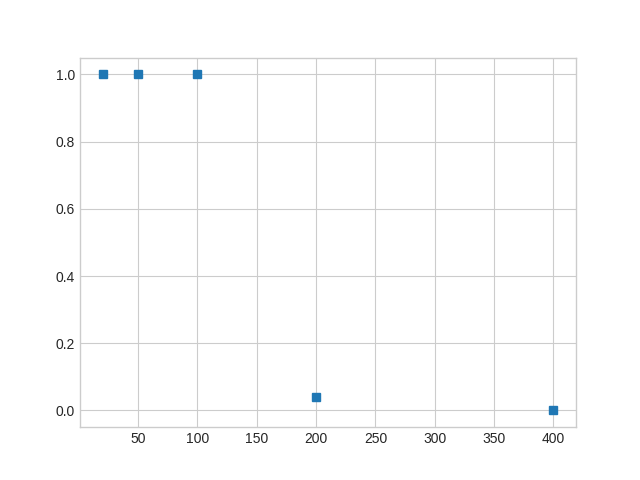

In [22]:
fig = plt.figure()
plt.plot(Ls, part, "s")

In [21]:
np.load(f"data/InPoint200/persistence.npy")

array([[0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.818775, 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.823925,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.8409  , 0.      , 0.      , 0.822175, 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 